In [1]:
%matplotlib widget
import pandas
import geopandas
import starepandas
import pystare
import matplotlib.pyplot as plt
import copy
import astropy
import numpy 
import glob
import pickle
import sqlalchemy
from itertools import repeat
import multiprocessing
import spires
import scipy

import modreaders
import postgis

In [2]:
starepandas.__version__

'0.6.2'

In [3]:
pystare.__version__

'0.8.8'

In [4]:
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
user = 'spires_rw'
pwd = 'spiresrw'
host= 'localhost'
db_name = 'spires'
uri = f'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

engine = sqlalchemy.create_engine(uri)

In [6]:
# Reds Lake: 
x = 1373
y = 566

#x = 566
#y = 1373


#x = 568
#y = 1374

#x = 565
#y = 1384

# Load ROI

In [7]:
with open('data/roi_4326_buffer_small.pickle', 'rb') as f:
    roi = pickle.load(f)
roi_sids = roi.iloc[0].sids

# Loading cell of interest

In [8]:
cells = postgis.read('cells', con=engine)

In [9]:
cells = starepandas.STAREDataFrame(cells, sids='centers_sids')
intersects = cells.to_stare_level(17, clear_to_level=True).stare_intersects(roi_sids)
cells = cells[intersects]
cells.reset_index(inplace=True, drop=True)

In [10]:
cell_df = cells[(cells.x==x) & (cells.y==y)]
cell = cell_df.to_dict(orient='records')[0]

# Loading swath granules

In [11]:
with open('/tablespace/spires/mod09.pickle', 'rb') as f:
    mod09_all = pickle.load(f)
    
mod09_all.sort_values('ts_start', inplace=True)
mod09_all.set_index('ts_start', inplace=True)

In [12]:
mod09 = mod09_all.loc['2021-01-01':'2021-01-31']

In [13]:
mod09.reset_index(inplace=True)

# Intersecting Swath with the Cell

In [14]:
intersects = mod09.stare_intersects(cell['buffer_sids_250'], n_partitions=1)
intersecting = copy.copy(mod09[intersects])
intersecting.reset_index(inplace=True)

In [15]:
trixels = intersecting.make_trixels(n_partitions=1)
intersecting.set_trixels(trixels, inplace=True)

In [16]:
intersecting['pts'] = geopandas.points_from_xy(intersecting.lon, intersecting.lat, crs=4326)

# Plots

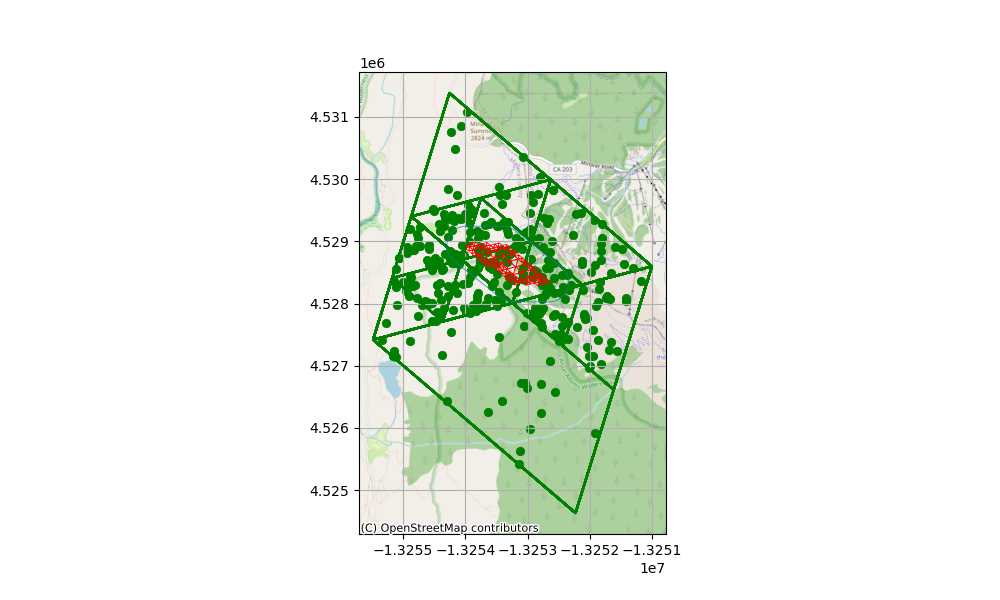

In [53]:
import contextily

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)

ax.grid(True)
ax.ticklabel_format(useOffset=False)

cell_df['buffer_250'].exterior.to_crs(epsg=3857).plot(ax=ax, zorder=9, linewidth=0.5)
cell_df['trixels_covers_18'].boundary.to_crs(epsg=3857).plot(ax=ax,  color='r', zorder=10, linewidth=0.5)

intersecting['pts'].to_crs(epsg=3857).plot(ax=ax, color='green', linewidth=0.6)
intersecting['trixels'].boundary.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=0.5)

contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik)

# Read MO09GAs

In [18]:
file_names = sorted(glob.glob('/tablespace/spires/mod09ga_jan2021/*.hdf'))
x_min = 1353
x_max = 1402
y_min = 552
y_max = 575
bbox = (x_min, x_max, y_min, y_max)

In [19]:
mod09ga = []
for file_name in file_names:
    mod09ga.append(modreaders.read_mod09ga(file_name, bbox))
mod09ga = pandas.concat(mod09ga)
mod09ga.reset_index(drop=True, inplace=True)

In [20]:
mod09ga = starepandas.STAREDataFrame(mod09ga).sort_values('ts_start')

In [21]:
mod09ga = mod09ga[(mod09ga.x==x) & (mod09ga.y==y)]

# Colocation on value

In [22]:
def find_ifov(ifovs, spectrum):
    if isinstance(spectrum, pandas.DataFrame) or isinstance(spectrum, pandas.Series):   
        spectrum = [spectrum['sur_refl_b01_1'], spectrum['sur_refl_b02_1'], spectrum['sur_refl_b03_1'], spectrum['sur_refl_b04_1'], 
                    spectrum['sur_refl_b05_1'], spectrum['sur_refl_b06_1'], spectrum['sur_refl_b07_1']]    
    
    rows = ifovs[(numpy.isclose(ifovs['500m Surface Reflectance Band 1'], spectrum[0])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 2'], spectrum[1])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 3'], spectrum[2])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 4'], spectrum[3])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 5'], spectrum[4])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 6'], spectrum[5])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 7'], spectrum[6])) ]
    return rows

In [23]:
selected = []
for index, row in mod09ga.iterrows():
    selected.append(find_ifov(mod09, row))

selected = pandas.concat(selected)
selected['ellipse_sids'] = starepandas.io.granules.modis.make_ellipse_sids(selected,n_partitions=2, level=19, crs=3310, modis_resolution=500)
selected['ellipse_trixels'] = selected.set_sids('ellipse_sids').make_trixels().boundary

In [24]:
def add_ndvi(df):
    ndvi = (df['500m Surface Reflectance Band 2'] - df['500m Surface Reflectance Band 1'])/(df['500m Surface Reflectance Band 2'] + df['500m Surface Reflectance Band 1'])
    df['ndvi'] = ndvi
    
def add_ndsi(df):
    ndsi = (df['500m Surface Reflectance Band 4'] - df['500m Surface Reflectance Band 6'])/(df['500m Surface Reflectance Band 4'] + df['500m Surface Reflectance Band 6'])
    df['ndsi'] = ndsi
    
def spectrum(df):    
    spectrum = df[['500m Surface Reflectance Band 1', 
                   '500m Surface Reflectance Band 2',
                   '500m Surface Reflectance Band 3',
                   '500m Surface Reflectance Band 4',
                   '500m Surface Reflectance Band 5',
                   '500m Surface Reflectance Band 6',
                   '500m Surface Reflectance Band 7']].to_numpy()
    return spectrum

add_ndsi(selected)
add_ndvi(selected)

In [25]:
selected.info()

<class 'starepandas.staredataframe.STAREDataFrame'>
Int64Index: 31 entries, 1241 to 60416
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ts_start                         31 non-null     datetime64[ns]
 1   index                            31 non-null     int64         
 2   lat                              31 non-null     float32       
 3   lon                              31 non-null     float32       
 4   sids                             31 non-null     int64         
 5   ts_end                           31 non-null     datetime64[ns]
 6   scan_pos                         31 non-null     uint16        
 7   track_pos                        31 non-null     uint16        
 8   500m Surface Reflectance Band 1  31 non-null     float64       
 9   500m Surface Reflectance Band 2  31 non-null     float64       
 10  500m Surface Reflectance Band 3  31 non-null

In [26]:
selected['ts'] = selected.ts_start.dt.strftime('%Y-%m-%d')

In [85]:
subset = selected[(selected.ts=='2021-01-17') |
                  (selected.ts=='2021-01-18') |
                  (selected.ts=='2021-01-22') |
                  (selected.ts=='2021-01-27')]

In [89]:
subset

ts_start     index    lat      lon                 sids  \
31942 2021-01-17 18:55:00   3651968 37.637 -119.057  3330897664296624110   
34836 2021-01-18 18:00:00   3103399 37.640 -119.057  3330897665816965868   
43314 2021-01-22 19:10:00  10912751 37.641 -119.058  3330897664442428558   
52620 2021-01-27 19:30:00   6959423 37.637 -119.059  3330897636008254061   

                   ts_end  scan_pos  track_pos  \
31942 2021-01-17 19:00:00      1584       1348   
34836 2021-01-18 18:05:00        31       1146   
43314 2021-01-22 19:15:00      2219       4029   
52620 2021-01-27 19:35:00      2571       2569   

       500m Surface Reflectance Band 1  500m Surface Reflectance Band 2  ...  \
31942                            0.263                            0.305  ...   
34836                            0.233                            0.369  ...   
43314                            1.033                            1.059  ...   
52620                            1.002                            0.983  ...   

                    sids17               sids18                 center_point  \
31942  3330897664270139409  3330897664295305234  POINT (-119.05667 37.63719)   
34836  3330897665813643281  3330897665813643282  POINT (-119.05676 37.63977)   
43314  3330897664437911569  3330897664437911570  POINT (-119.05757 37.64119)   
52620  3330897635983753233  3330897636000530450  POINT (-119.05891 37.63705)   

       area  level                                       ellipse_sids  \
31942 0.319     14  [3330897663766822927, 3330897635883089937, 333...   
34836 5.112     12  [3330895849143140366, 3330897637997019150, 333...   
43314 0.319     14  [3330897664303693839, 3330897665109000208, 333...   
52620 1.278     13  [3330896553517776911, 3330896555128389647, 333...   

                                         ellipse_trixels  ndsi   ndvi  \
31942  MULTILINESTRING ((-119.05589 37.63512, -119.05... 0.811  0.075   
34836  MULTILINESTRING ((-119.07052 37.64503, -119.08... 0.370  0.226   
43314  MULTILINESTRING ((-119.05313 37.64218, -119.05... 0.253  0.013   
52620  MULTILINESTRING ((-119.05589 37.63512, -119.05... 0.413 -0.010   

               ts  
31942  2021-01-17  
34836  2021-01-18  
43314  2021-01-22  
52620  2021-01-27  

[4 rows x 40 columns]

In [90]:
subset[['ts', 'ellipse_trixels']].set_geometry('ellipse_trixels').to_file('s.gpkg', driver='GPKG')

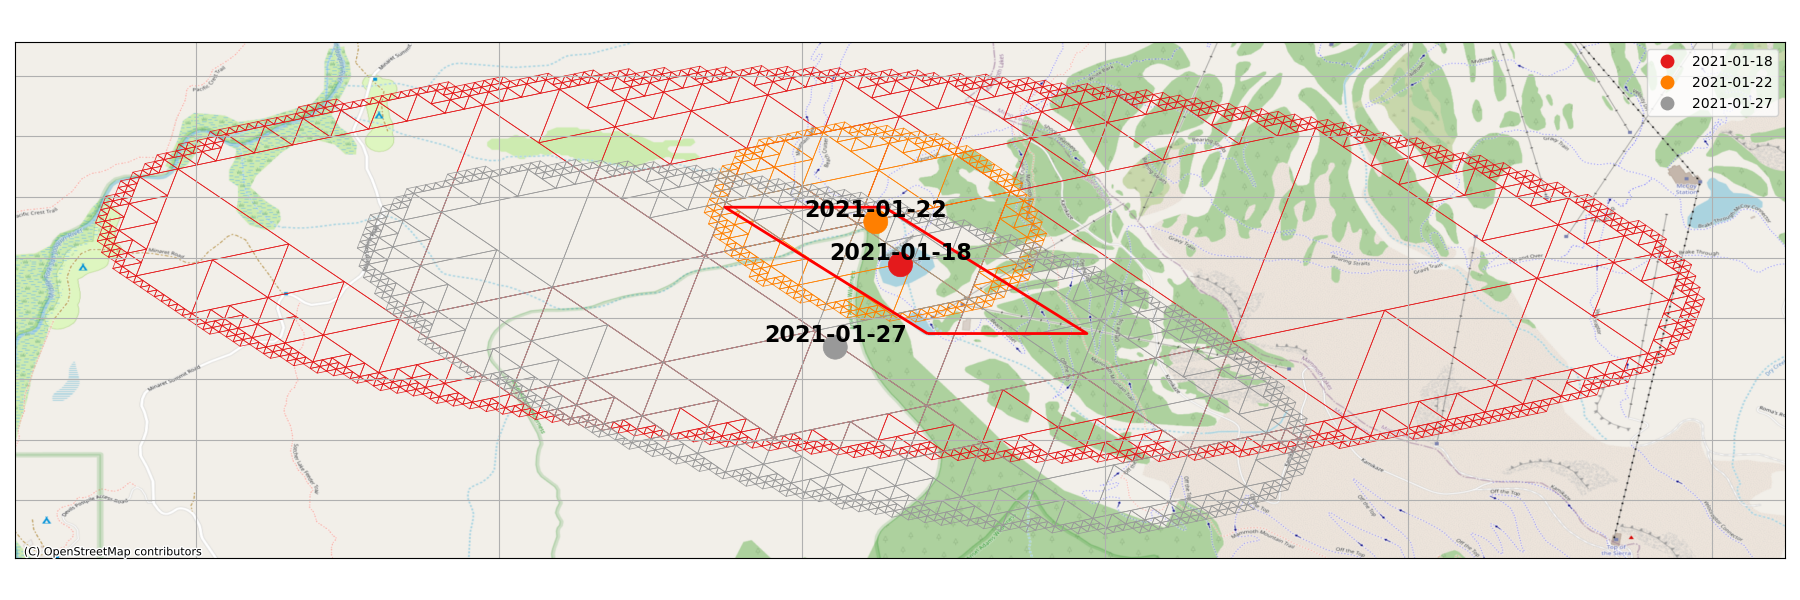

In [83]:
fig = plt.figure(figsize=(18, 6), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)


fig.tight_layout()

ax.grid(True)
#ax.ticklabel_format(useOffset=False)

subset.set_geometry('center_point').plot(ax=ax, zorder=2, trixels=False, linewidth=0.5, markersize=300, legend=True, column='ts', cmap='Set1')
subset.set_geometry('ellipse_trixels').plot(ax=ax, zorder=1, linewidth=0.5, column='ts', trixels=False, boundary=True, cmap='Set1')
cell_df['polygons_4326'].boundary.plot(ax=ax,  color='r', zorder=10, linewidth=2)

#subset.set_geometry('center_point', inplace=True)
for idx, row in subset.iterrows():
    ax.annotate(text=row['ts'], xy=row['center_point'].coords[0], horizontalalignment='center', verticalalignment='bottom', zorder=10, fontsize=16, weight='bold')
    
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)


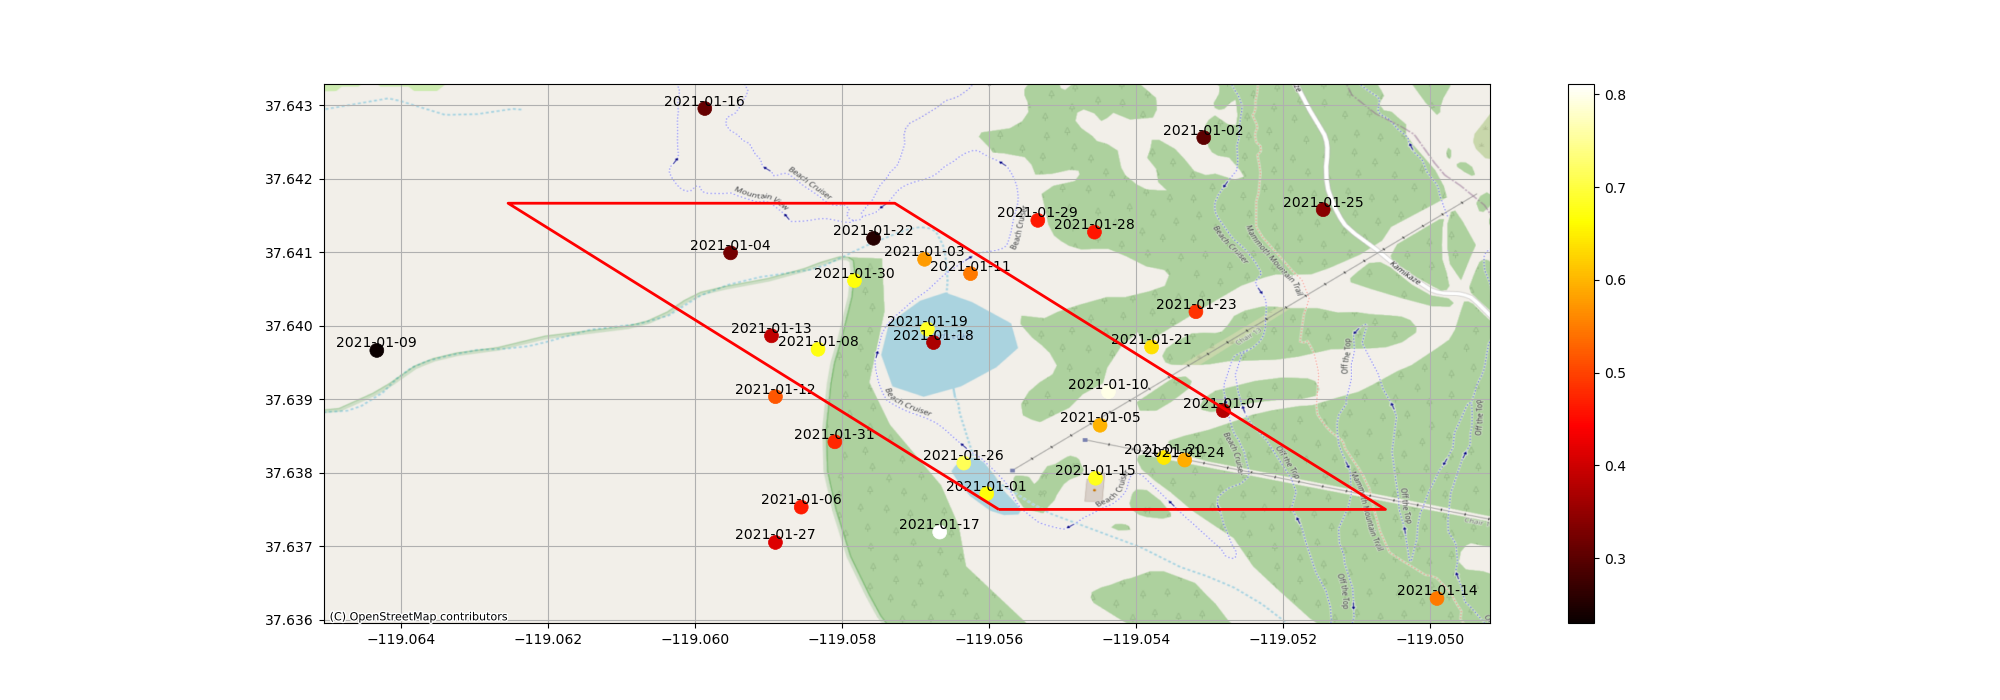

In [49]:
subset=selected
fig = plt.figure(figsize=(20, 7), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)

ax.grid(True)
ax.ticklabel_format(useOffset=False)

ax = subset.set_geometry('center_point').plot(ax=ax, zorder=2, trixels=False, linewidth=0.5, markersize=100, legend=True, column='ndsi', cmap='hot')
cell_df['polygons_4326'].boundary.plot(ax=ax,  color='r', zorder=10, linewidth=2)

subset.set_geometry('center_point', inplace=True)
for idx, row in subset.iterrows():
    ax.annotate(text=row['ts'], xy=row['center_point'].coords[0], horizontalalignment='center', verticalalignment='bottom')
    
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

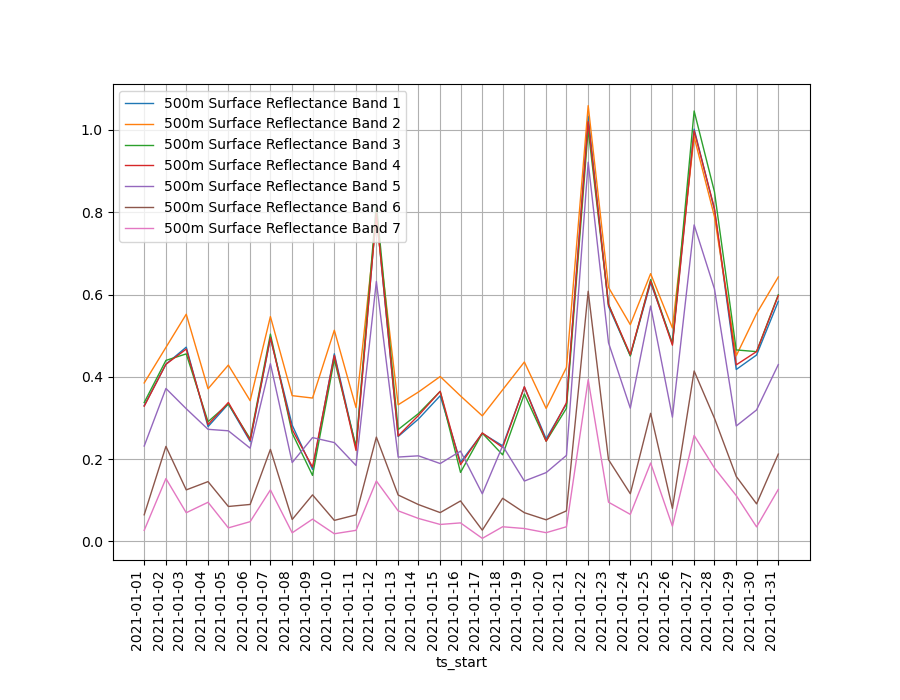

In [50]:
fig = plt.figure(figsize=(9, 7), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)

df = pandas.DataFrame(selected)

lw  = 1
df.plot(ax=ax, y='500m Surface Reflectance Band 1', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 2', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 3', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 4', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 5', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 6', x='ts_start', lw=lw)
df.plot(ax=ax, y='500m Surface Reflectance Band 7', x='ts_start', lw=lw, xticks=selected['ts_start'], rot=90)

ax.grid(True)

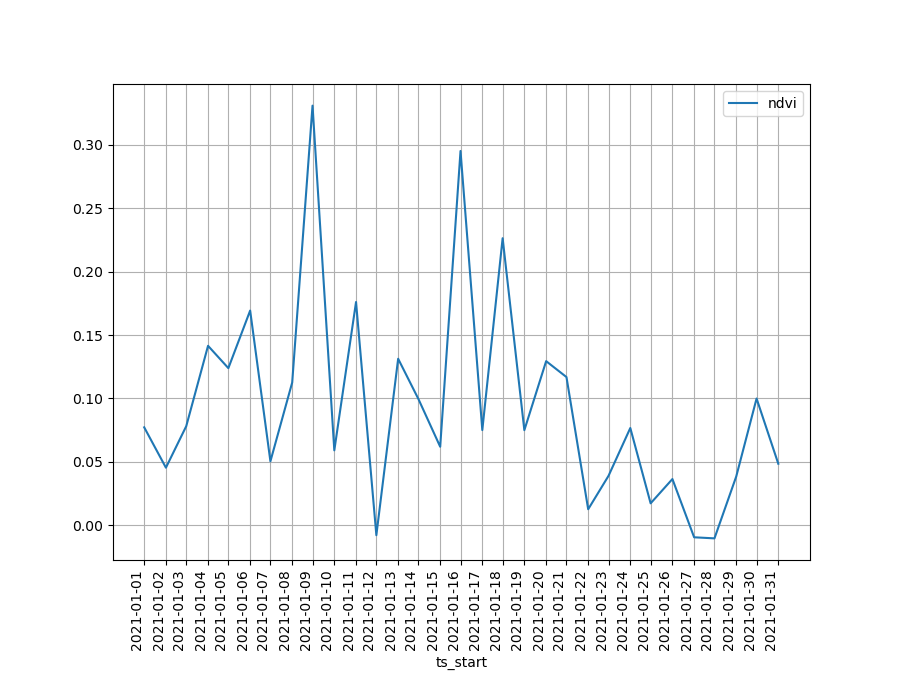

In [51]:
fig = plt.figure(figsize=(9, 7), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)

#pandas.DataFrame(selected).plot(ax=ax, y='ndsi', x='ts_start')
pandas.DataFrame(selected).plot(ax=ax, y='ndvi', x='ts_start', xticks=selected['ts_start'], rot=90)
ax.grid(True)

# Timeseries

In [32]:
lut = spires.load_lut('data/LUT_MODIS.mat')
r0_grid_raw = scipy.io.loadmat('data/h08v05_R0.mat')['R0']
r0_cell = r0_grid_raw[x, y]

In [33]:
with open('/tablespace/spires/r0/r0_stare17_4.pickle', 'rb') as f:
    r0_stare = pickle.load(f)

In [34]:
s = copy.copy(selected[(selected.cloud==0) & (selected.SensorZenith<55)])# (selected.cloud==0)])

In [55]:
shade = numpy.zeros(7)

results_grid = []
results_stare = []
for idx, row in s.iterrows():
    r_spectrum = spectrum(row)
    solar_z = row['SolarZenith']        
    
    candidates = r0_stare[r0_stare.stare_intersects(row.sids)]                        
    r0_best = candidates.iloc[(candidates.scan_pos-row.scan_pos).abs().argsort().iloc[:1]]        
    r0_best = spectrum(r0_best)[0]#[mod09_bandnames].to_numpy()[0]        
    
    res_grid, model_refl = spires.speedy_invert(lut, r_spectrum, r0_cell, solar_z, shade, mode=4)    
    res_stare, model_refl = spires.speedy_invert(lut, r_spectrum, r0_best, solar_z, shade, mode=4)
    
    results_grid.append(res_grid.x)
    results_stare.append(res_stare.x)
    
s['fSCA_grid'] = numpy.array(results_grid).T[0].T
s['fSCA_stare'] = numpy.array(results_stare).T[0].T

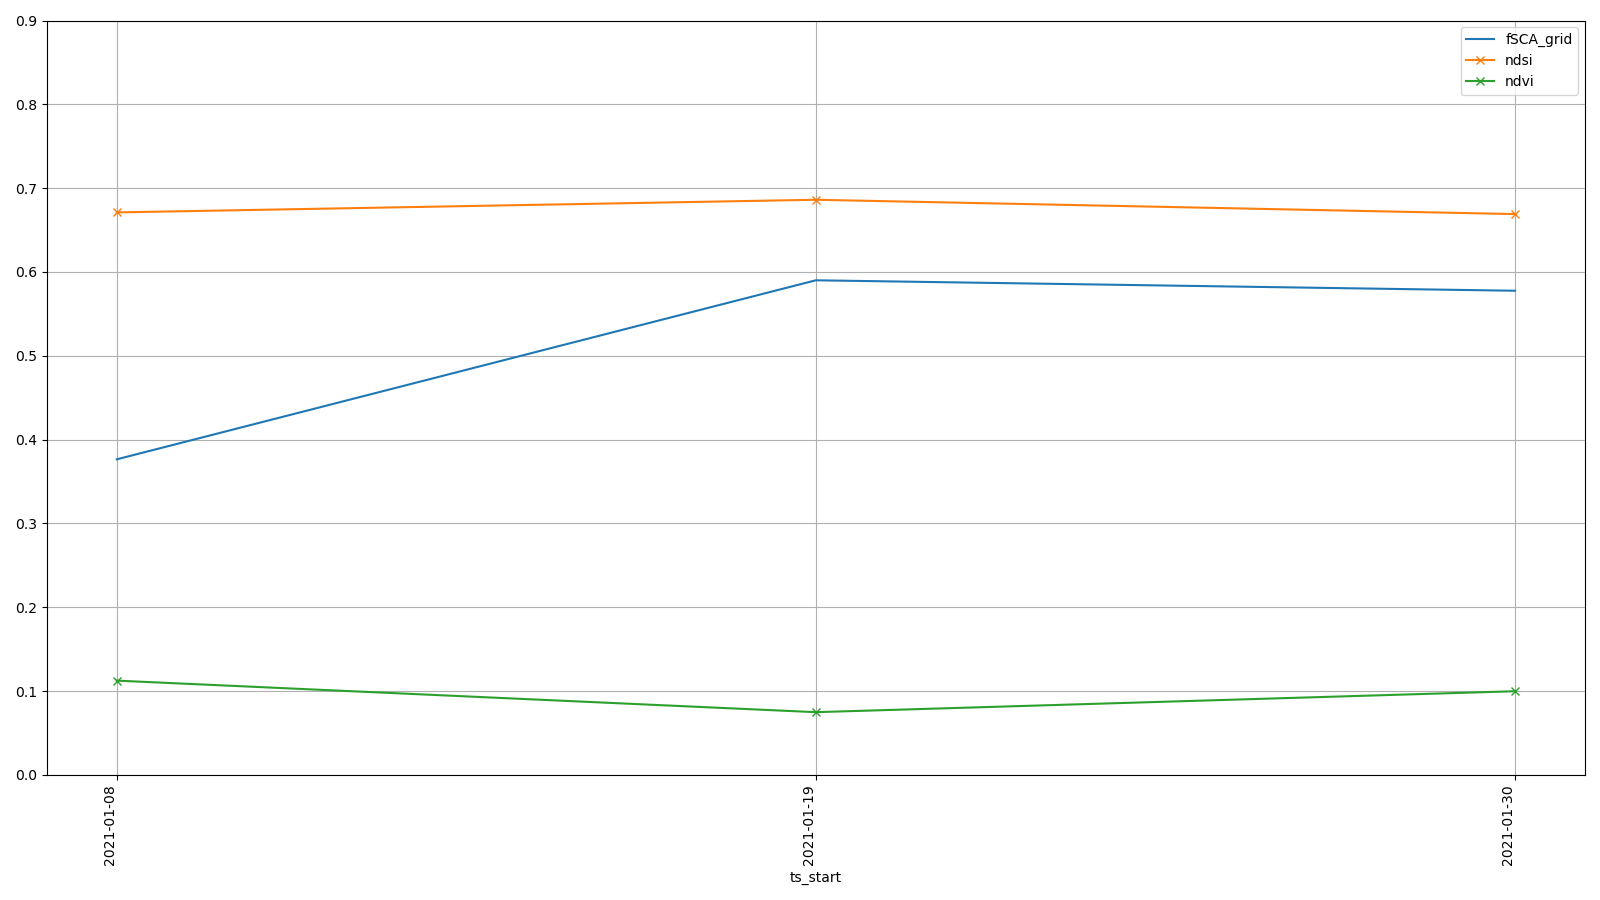

In [56]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)


df = pandas.DataFrame(s)

#df.plot(ax=ax, y='fSCA_stare', x='ts_start', xticks=s['ts_start'], rot=90, marker='x')
df.plot(ax=ax, y='fSCA_grid', x='ts_start', xticks=s['ts_start'], rot=90)
df.plot(ax=ax, y='ndsi', x='ts_start', marker='x')
df.plot(ax=ax, y='ndvi', x='ts_start', marker='x', xticks=s['ts_start'], rot=90)

ax.set_ylim(0, 0.9)
fig.tight_layout()
ax.grid(True)

# Timeseries

In [37]:
location = geopandas.read_file('data/mammoth.gpkg')
location = location[location.name=='outpost']
location = starepandas.STAREDataFrame(location)
location.set_sids(location.make_sids(level=19), inplace=True)
location.add_trixels(inplace=True)

In [38]:
location = geopandas.points_from_xy([-119.056722], [37.639810], crs=4326)
location = starepandas.STAREDataFrame(geometry=location)
location.set_sids(location.make_sids(level=15), inplace=True)
location.add_trixels(inplace=True)

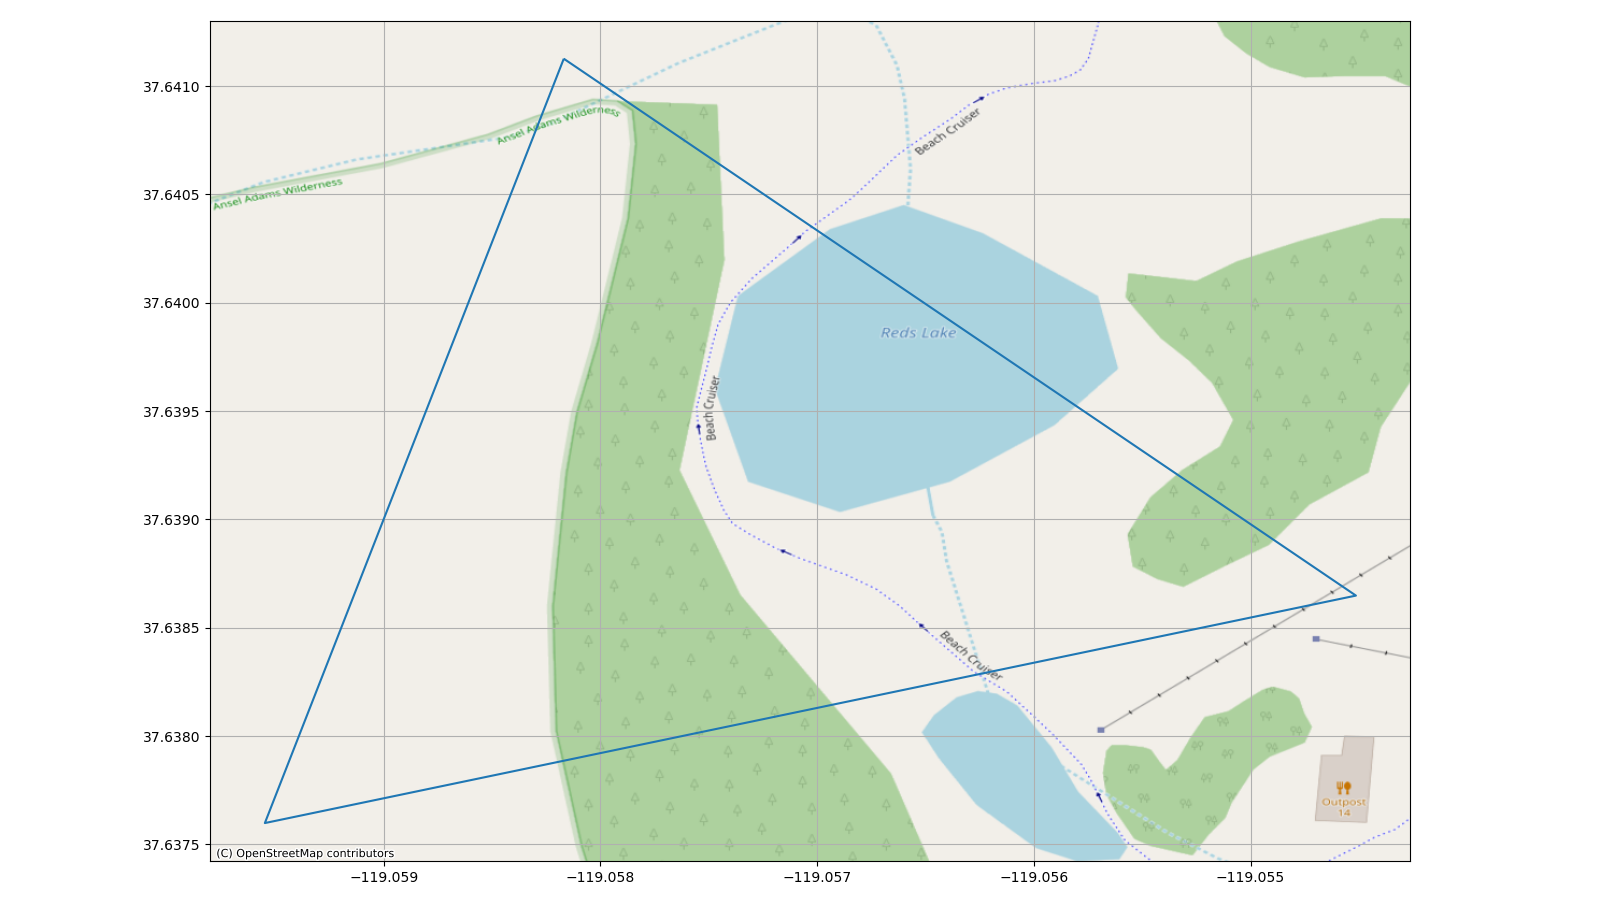

In [39]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot()
ax.ticklabel_format(useOffset=False)
fig.tight_layout()

ax.grid(True)
ax.ticklabel_format(useOffset=False)

location.plot(ax=ax)

contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

In [40]:
sid = location.sids.iloc[0]

In [41]:
s = mod09[mod09.to_stare_level(15).stare_intersects(sid)]
s = s[(s.cloud==0) & (s.SensorZenith<55) ]

In [42]:
results_s = []
for idx, row in s.iterrows():
    r_spectrum = spectrum(row)
    solar_z = row['SolarZenith']        
    
    candidates = r0_stare[r0_stare.stare_intersects(row.sids)]                        
    r0_best = candidates.iloc[(candidates.scan_pos-row.scan_pos).abs().argsort().iloc[:1]]        
    r0_best = spectrum(r0_best)[0]
     
    res_stare, model_refl = spires.speedy_invert(lut, r_spectrum, r0_best, solar_z, shade, mode=4)    
    
    results_s.append(res_stare.x)

In [43]:
df = pandas.DataFrame(s)
df['fSCA_stare'] = numpy.array(results_s).T[0].T
add_ndsi(df)
add_ndvi(df)

In [44]:
df = df[['fSCA_stare', 'ndsi', 'ndvi']].groupby(df.ts_start.dt.date).mean().reset_index()

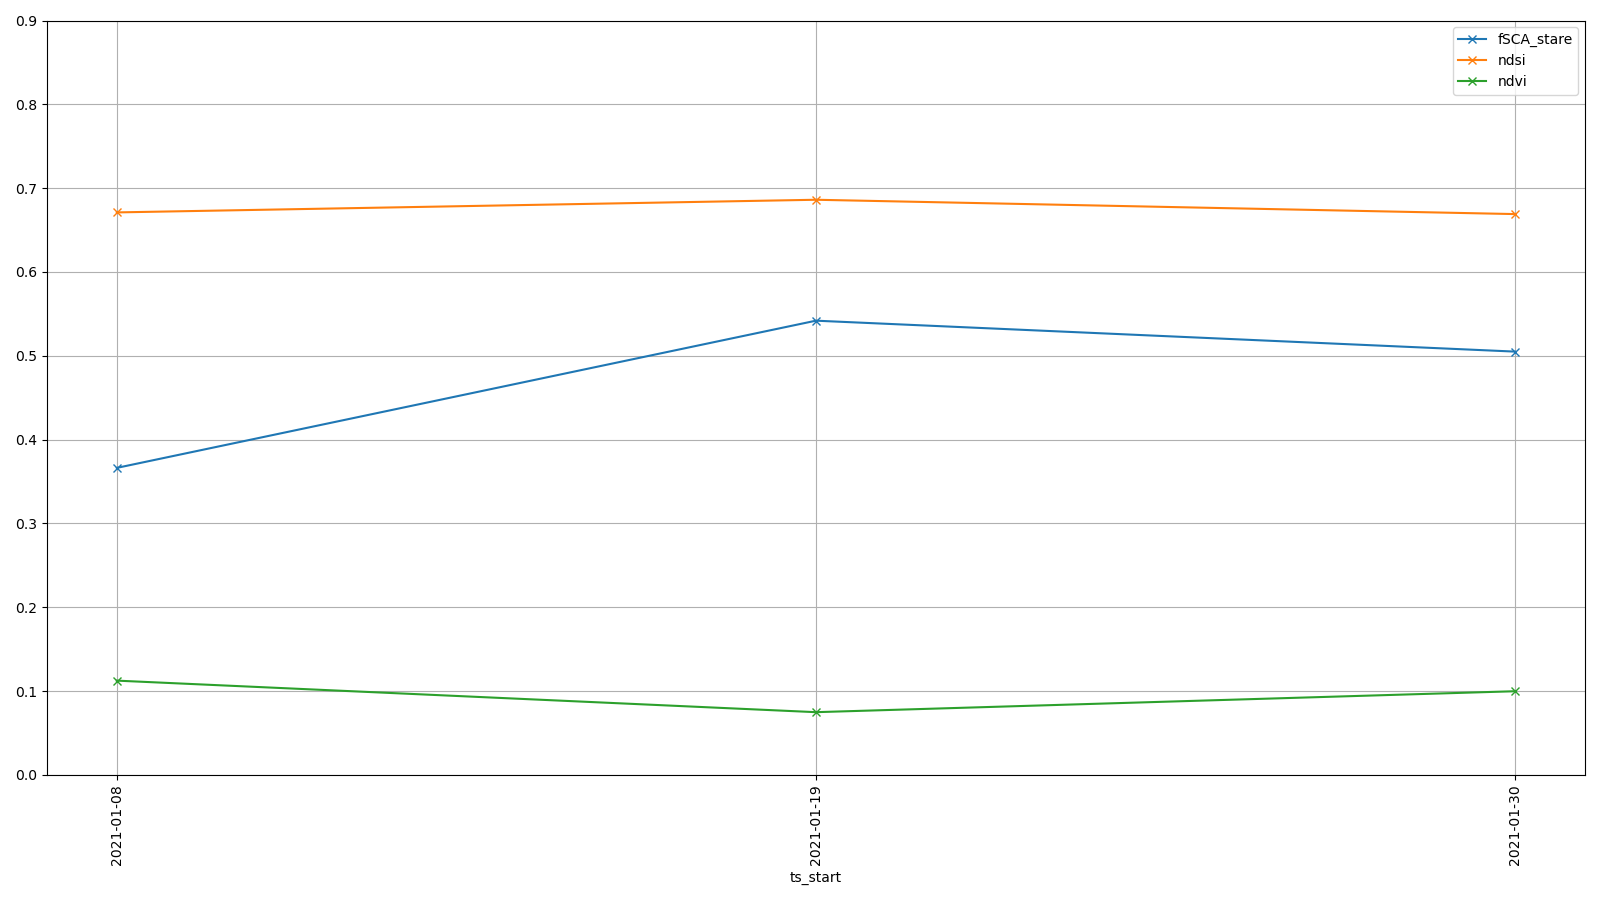

In [45]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot()

ax.ticklabel_format(useOffset=False)

df.plot(ax=ax, y='fSCA_stare', x='ts_start',  rot=90, marker='x')
df.plot(ax=ax, y='ndsi', x='ts_start',  rot=90, marker='x')
df.plot(ax=ax, y='ndvi', x='ts_start', xticks=df['ts_start'], rot=90, marker='x')
ax.set_ylim(0, 0.9)
fig.tight_layout()

ax.grid(True)

In [46]:
df

ts_start  fSCA_stare  ndsi  ndvi
0  2021-01-08       0.366 0.671 0.113
1  2021-01-19       0.542 0.686 0.075
2  2021-01-30       0.505 0.669 0.100